# Reproducing Biomedical Image Segmentation in the U-Net paper

In this notebook we try to fully reproduce the method presented in the paper ["U-Net: Convolutional Networks for Biomedical Segmentation"](https://arxiv.org/pdf/1505.04597.pdf), particularly, the results presented in table 2 and the pixel error of the U-Net reported in table 1.
The following implementation was carried out without using the pre-existing code, made available by the authors.

## How does U-Net work ?

explain the architecture and challenge (see also video presentation)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cv2 as cv
import os
import shutil
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data import download_all_data, ImageDataset, ImageDataset_test, preprocess_gt
from network import Unet
from functions import weighted_map, input_size_compute, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

# Dataset


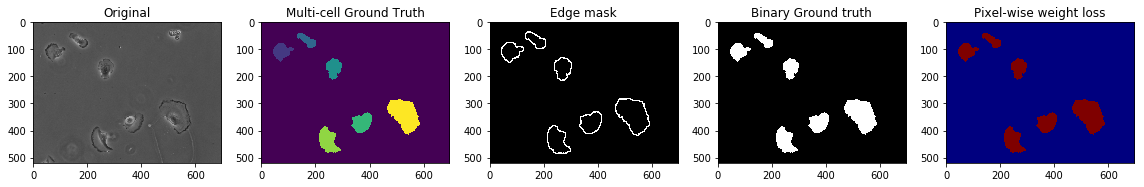

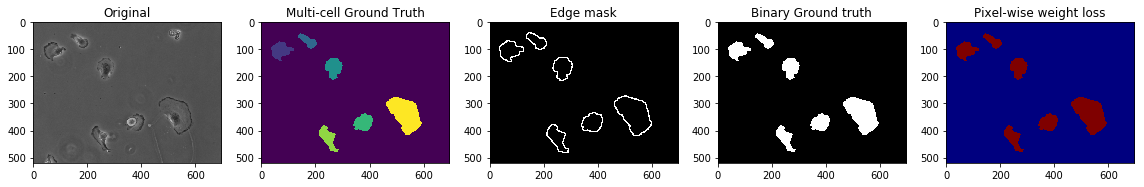

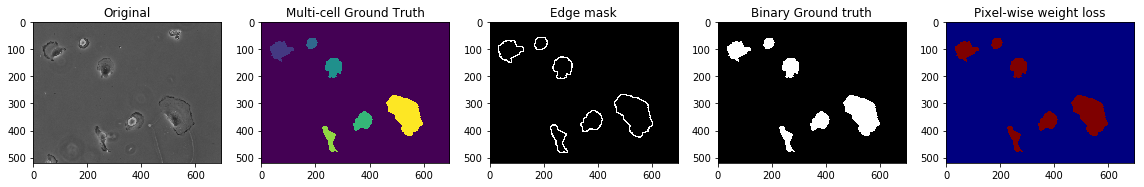

In [5]:
# Download data
download_all_data()

# Specify which dataset to analyse
DATASET = 'PhC-C2DH-U373'
# DATASET = 'ISBI2012'
#DATASET = 'DIC-C2DH-HeLa'

ISBI2012 = False

if DATASET is 'ISBI2012':
    ISBI2012 = True

target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_ST", "SEG")
target_GT_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")
target_GT = os.listdir(target_GT_path)

for image in target_GT:
    try:
        os.remove(os.path.join(target_path, image))
    except:
        pass

target = os.listdir(target_path)

for image in target_GT:
    shutil.copyfile(os.path.join(target_GT_path, image), os.path.join(target_path, image))

for i in range(3):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"))
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt / 65536 * 255
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training)
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    h, w = gt_bin.shape
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,h,w))) / 255).numpy().reshape((h,w))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

# Data Augmentation

IMAGE SHAPE (196, 196) 214 380


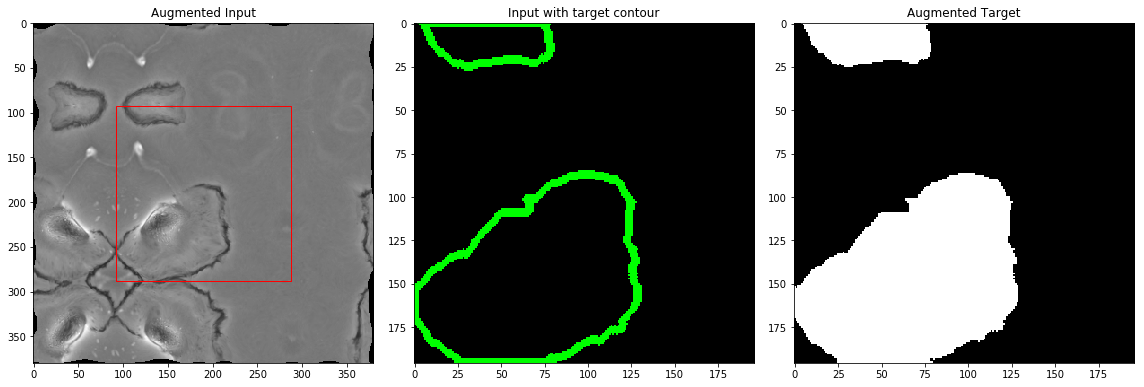

In [6]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
if DATASET == "DIC-C2DH-HeLa":
    crop = 388
else:
    crop = 196

data = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012, crop=crop)   # For training + validation
orig_img = cv.imread(os.path.join(root_dir, '01', os.listdir(os.path.join(root_dir, "01"))[0]), -1)

img, gt = data[0]

original_size, input_size, _ = input_size_compute(gt)
pad = int((input_size - original_size) / 2)

fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

rect = patches.Rectangle((pad,pad),original_size,original_size,linewidth=1,edgecolor='r',facecolor='none')
gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
image = cv.cvtColor(img.reshape(img.shape[1:])[pad:pad+original_size,pad:pad+original_size].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
cv.drawContours(image, contours, -1, (0, 255, 0), 3)

ax0.imshow(img.reshape(img.shape[1:]), cmap='gray')
ax0.add_patch(rect)
ax0.set_title('Augmented Input')
ax1.imshow(image)
ax1.set_title('Input with target contour')
ax2.imshow(gt, cmap='gray')
ax2.set_title('Augmented Target')

fig.tight_layout()
plt.show()

In [7]:
# REMOVE ME
val = np.ones((len(data)*10,))
for j in range(2):
    val = np.ones((len(data)*1,))
    for i, b in enumerate(data):
        img, gt = b
        val[i+j*len(data)*0] =  float(gt.sum()) / (gt.shape[1] * gt.shape[2])
        print("VAL", val[i])
#         plt.imshow(gt.reshape((gt.shape[1], gt.shape[2])))
#         plt.show()
    print(np.mean(val)*100, np.std(val))

IMAGE SHAPE (196, 196) 240 395
VAL 0.26934089962515617
IMAGE SHAPE (196, 196) 256 383
VAL 0.298807788421491
IMAGE SHAPE (196, 196) 223 402
VAL 0.32666076634735525
IMAGE SHAPE (196, 196) 219 438
VAL 0.32785818408996253
IMAGE SHAPE (196, 196) 211 411
VAL 0.3493336109954186
IMAGE SHAPE (196, 196) 234 490
VAL 0.36312994585589337
IMAGE SHAPE (196, 196) 222 441
VAL 0.3513379841732611
IMAGE SHAPE (196, 196) 285 461
VAL 0.32923781757601
IMAGE SHAPE (196, 196) 271 490
VAL 0.2821740941274469
IMAGE SHAPE (196, 196) 294 209
VAL 0.31020928779675133
IMAGE SHAPE (196, 196) 256 205
VAL 0.29164931278633904
IMAGE SHAPE (196, 196) 317 213
VAL 0.2771241149521033
IMAGE SHAPE (196, 196) 288 211
VAL 0.24846418159100375
IMAGE SHAPE (196, 196) 308 205
VAL 0.22665035401915867
IMAGE SHAPE (196, 196) 296 194
VAL 0.18481882548937942
IMAGE SHAPE (196, 196) 17 114
VAL 0.19806851311953352
IMAGE SHAPE (196, 196) 6 146
VAL 0.19606413994169097
IMAGE SHAPE (196, 196) 51 154
VAL 0.1562109537692628
IMAGE SHAPE (196, 196) 3

IMAGE SHAPE (196, 196) 115 9
VAL 0.12976364014993752
IMAGE SHAPE (196, 196) 108 490
VAL 0.16542586422324032
IMAGE SHAPE (196, 196) 103 17
VAL 0.13752082465639318
IMAGE SHAPE (196, 196) 93 486
VAL 0.15543002915451895
IMAGE SHAPE (196, 196) 163 480
VAL 0.13830174927113703
IMAGE SHAPE (196, 196) 149 28
VAL 0.1357246980424823
IMAGE SHAPE (196, 196) 106 21
VAL 0.1408527696793003
IMAGE SHAPE (196, 196) 86 14
VAL 0.13767700957934195
IMAGE SHAPE (196, 196) 238 2
VAL 0.1891399416909621
IMAGE SHAPE (196, 196) 240 1
VAL 0.17016347355268638
IMAGE SHAPE (196, 196) 239 1
VAL 0.1803935860058309
IMAGE SHAPE (196, 196) 264 0
VAL 0.1589441899208663
IMAGE SHAPE (196, 196) 235 0
VAL 0.147881091211995
IMAGE SHAPE (196, 196) 276 0
VAL 0.1323146605581008
IMAGE SHAPE (196, 196) 293 3
VAL 0.12309975010412329
IMAGE SHAPE (196, 196) 310 18
VAL 0.11180237401082882
IMAGE SHAPE (196, 196) 263 5
VAL 0.11854435651811746
IMAGE SHAPE (196, 196) 159 494
VAL 0.1153685964181591
IMAGE SHAPE (196, 196) 294 2
VAL 0.128982715

VAL 0.2103029987505206
IMAGE SHAPE (196, 196) 263 5
VAL 0.20678883798417327
IMAGE SHAPE (196, 196) 264 10
VAL 0.23841628488129946
IMAGE SHAPE (196, 196) 251 3
VAL 0.2167326114119117
IMAGE SHAPE (196, 196) 235 22
VAL 0.20012494793835903
IMAGE SHAPE (196, 196) 246 24
VAL 0.19512703040399834
IMAGE SHAPE (196, 196) 268 0
VAL 0.17823302790503956
IMAGE SHAPE (196, 196) 236 12
VAL 0.20301436901291128
IMAGE SHAPE (196, 196) 252 0
VAL 0.20038525614327363
IMAGE SHAPE (196, 196) 250 2
VAL 0.15816326530612246
IMAGE SHAPE (196, 196) 122 24
VAL 0.13949916701374426
IMAGE SHAPE (196, 196) 295 44
VAL 0.1081320283215327
IMAGE SHAPE (196, 196) 105 15
VAL 0.13283527696793002
IMAGE SHAPE (196, 196) 137 42
VAL 0.11305185339441899
IMAGE SHAPE (196, 196) 67 46
VAL 0.12198042482299042
IMAGE SHAPE (196, 196) 78 47
VAL 0.12958142440649728
IMAGE SHAPE (196, 196) 115 25
VAL 0.1264316951270304
IMAGE SHAPE (196, 196) 128 64
VAL 0.1493127863390254
IMAGE SHAPE (196, 196) 298 0
VAL 0.16178154935443564
IMAGE SHAPE (196,

# Training

In [ ]:
# Parameters:
val_per = 0.2
tr_per  = 1.0 - val_per
batch_size = 1
epochs = 2

In [ ]:
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
train_dataset = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

samp_tr  = int(np.round(tr_per  * len(train_dataset)))
samp_val = int(np.round(val_per * len(train_dataset)))

# We round numbers so that we do not exceed total number of samples
while samp_tr + samp_val > len(train_dataset):
    samp_val += -1

# We generate an order vector to shuffle the samples before each fold for the cross validation  
order = np.arange(len(train_dataset))
np.random.shuffle(order)

# Suffle the training set
train_dataset = [train_dataset[idx] for idx in order]

# Divide between training and validation sets by order (in notebook we only use a few images for speed purposes)
train_set = train_dataset[0:2]
val_set   = train_dataset[2:3]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True)

# Shift values in order for next fold of cross validation (a shift of samp_val)
order = np.append(order[samp_val:], order[0:samp_val])
        
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')

else:
    device = torch.device('cpu')
    print('Running on the CPU')

In [ ]:
# To be called as: training(unet, train_loader, val_loader, epochs, batch_size, device, fold_dir):

train_dir = os.path.join(CUR_DIR, 'nb_train')
maybe_mkdir_p(train_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)

optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, threshold=1e-5, eps=1e-6)
my_patience = 0

for epoch in range(epochs+1):
    
    print(' ')
    print('Epoch:', epoch)

    start = time()
    total_loss = 0
    previous_loss = 0
    total_loss_val = 0
    previous_loss_val = 0
    start_eval_train = 0
    start_eval_val = 0

    for batch in train_loader:

        optimizer.zero_grad()

        images, labels = batch
        preds = unet(images.to(device)) # pass batch to the unet

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :]  # background
        ll[:,1,:,:] = labels[:, 0, :, :]  # cell
        ll = ll.to(device)

        weight_maps = weighted_map(labels).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        loss = criterion(preds, ll)

        loss.backward() # compute the gradients using backprop
        optimizer.step() # update the weights

        total_loss += loss

        preds = preds.argmax(dim=1)

        for idx in range(preds.shape[0]):
            if start_eval_train == 0 and idx == 0: # First time in epoch we initialize train_eval
                train_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_train += 1
            else:
                np.concatenate((train_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    train_eval_epoch = np.mean(train_eval, axis=1)

    with torch.no_grad():
        for batch in val_loader:
            
            images, labels = batch
            preds = unet(images.to(device))

            pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
            preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

            ll = torch.empty_like(preds)
            ll[:,0,:,:] = 1 - labels[:, 0, :, :] # background
            ll[:,1,:,:] = labels[:, 0, :, :] # cell
            ll = ll.to(device)

            weight_maps = weighted_map(labels).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
            loss = criterion(preds, ll)

            total_loss_val += loss

            preds = preds.argmax(1)

            for idx in range(preds.shape[0]):
                if start_eval_val == 0 and idx == 0: # First time in epoch we initialize val_eval
                    val_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                    start_eval_val += 1
                else:
                    np.concatenate((val_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    val_eval_epoch = np.mean(val_eval, axis=1)

    scheduler.step(total_loss_val / (len(val_loader) * batch_size)) # update the lr

    for param_group in optimizer.param_groups: l_rate = param_group['lr']

    loss_epoch     = total_loss / (len(train_loader) * batch_size)
    loss_epoch_val = total_loss_val / (len(val_loader) * batch_size)

    if loss_epoch_val < (loss_best_epoch * (1.0 - scheduler.threshold)):
        loss_best_epoch = loss_epoch_val
        print('New best epoch!')
        my_patience = 0
        PATH = os.path.join(train_dir, 'models', 'unet_weight_save_best.pth')
        torch.save(unet.state_dict(), PATH)
        print('Model has been saved:')
        print(PATH)
    else:
        my_patience += 1

    print('Current lr is:             ', l_rate                                      )
    print('Patience is:                {}/{}'.format(my_patience, scheduler.patience))
    print('Mean IoU training:         ', "{:.6f}".format(train_eval_epoch[0])        )
    print('Mean PE training:          ', "{:.6f}".format(train_eval_epoch[1])        )
    print('Mean IoU validation:       ', "{:.6f}".format(val_eval_epoch[0])          )
    print('Mean PE validation:        ', "{:.6f}".format(val_eval_epoch[1])          )
    print('Total training loss:       ', "{:.6f}".format(loss_epoch.item())          )
    print('Total validation loss:     ', "{:.6f}".format(loss_epoch_val.item())      )
    print('Best epoch validation loss:', "{:.6f}".format(loss_best_epoch.item())     )
    print('Epoch duration:            ', "{:.6f}".format(time()-start), 's'          )
    print('                                                                         ')

    # Save progress (evaluation metrics and loss)
    if epoch == 0:
        train_eval_progress_iou = [train_eval_epoch[0]]
        train_eval_progress_pe  = [train_eval_epoch[1]]
        val_eval_progress_iou   = [val_eval_epoch[0]]
        val_eval_progress_pe    = [val_eval_epoch[1]]
        loss_progress           = [loss_epoch.item()]
        loss_progress_val       = [loss_epoch_val.item()]
    elif epoch > 0:
        train_eval_progress_iou = np.concatenate((train_eval_progress_iou, [train_eval_epoch[0]]))
        train_eval_progress_pe  = np.concatenate((train_eval_progress_pe, [train_eval_epoch[1]]) )
        val_eval_progress_iou   = np.concatenate((val_eval_progress_iou, [val_eval_epoch[0]])    )
        val_eval_progress_pe    = np.concatenate((val_eval_progress_pe, [val_eval_epoch[1]])     )
        loss_progress           = np.append(loss_progress, [loss_epoch.item()]                   )
        loss_progress_val       = np.append(loss_progress_val, [loss_epoch_val.item()]           )

    np.savetxt(os.path.join(train_dir, 'train_eval_iou.out'), train_eval_progress_iou)
    np.savetxt(os.path.join(train_dir, 'train_eval_pe.out' ), train_eval_progress_pe )
    np.savetxt(os.path.join(train_dir, 'val_eval_iou.out'  ), val_eval_progress_iou  )
    np.savetxt(os.path.join(train_dir, 'val_eval_pe.out'   ), val_eval_progress_pe   )
    np.savetxt(os.path.join(train_dir, 'loss.out'          ), loss_progress          )
    np.savetxt(os.path.join(train_dir, 'loss_val.out'      ), loss_progress_val      )

    if l_rate < 10 * scheduler.eps and my_patience == scheduler.patience:
        print(f'LR dropped below {10 * scheduler.eps}!')
        print('Stopping training')
        break

    if my_patience == scheduler.patience: my_patience = 0

print('Training is finished as epoch {} has been reached'.format(epochs))

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    original_size, input_size, _ = input_size_compute(gt)
    pad = int((input_size - original_size) / 2)

    ax0.imshow(images[0, 0, pad:original_size+pad, pad:original_size+pad].detach(), cmap='gray')
    ax1.imshow(preds[0, :, :].detach(), cmap='gray')
    ax2.imshow(labels[0, 0, :, :].detach(), cmap='gray')

# Testing

In [ ]:
NETWORK = 'nb_test/unet_weight_save_5000.pth'
NETWORK = 'models/DIC-C2DH-HeLa/fold0/models/unet_weight_save_350.pth'
model_path = os.path.join(CUR_DIR, NETWORK)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

# Get test data
test_dataset  = ImageDataset_test(root_dir, ISBI2012=ISBI2012)   
test_dataset  = [test_dataset[idx] for idx in range(len(test_dataset))]
test_set      = test_dataset[0: 1]                
test_loader   = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Make directory for test outputs (assumes .pth format)
output_dir = os.path.join(model_path[0:len(model_path)-4], '_test')
maybe_mkdir_p(output_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
# To be called as: testing(unet, test_loader, batch_size, device, output_dir)

start = time()
start_eval_test = 0
idx = 0

maybe_mkdir_p(os.path.join(output_dir, 'images'))
maybe_mkdir_p(os.path.join(output_dir, 'preds' ))
maybe_mkdir_p(os.path.join(output_dir, 'labels'))

for batch in test_loader:
    
    image, label = batch

    pred = unet(image.to(device))

    pad = int((pred.shape[-1] - label.shape[-1]) / 2)
    pred = pred[:, :, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].argmax(dim=1)

    save_image(image[0, 0, :, :],         os.path.join(output_dir, 'images', f'image{idx}.tif'))
    save_image(label[0, 0, :, :].float(), os.path.join(output_dir, 'preds',  f'pred{idx}.tif' ))
    save_image(pred[0, :, :].float(),     os.path.join(output_dir, 'labels', f'label{idx}.tif'))

    if start_eval_test == 0: 
        test_eval = evaluation_metrics(pred[0, :, :].detach(), label[0, 0, :, :].detach())
        start_eval_test += 1
    else:
        np.concatenate((test_eval, evaluation_metrics(pred[0, :, :].detach(), label[0, 0, :, :].detach())), axis=1)

test = np.mean(test_eval, axis=1)

test_iou = [test[0]]
test_pe  = [test[1]]
np.savetxt(os.path.join(output_dir, 'test_iou.out'), test_iou)
np.savetxt(os.path.join(output_dir, 'test_pe.out' ), test_pe )

print('Mean IoU testing:', "{:.6f}".format(test[0])          )
print('Mean PE testing :', "{:.6f}".format(test[1])          )
print('Testing took    :', "{:.6f}".format(time()-start), 's')
print('                                                     ')

print('Testing is finished')

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].detach(), cmap='gray')
    ax1.imshow(pred[0, :, :].detach(),  cmap='gray')
    ax2.imshow(label[0, 0, :, :].detach(), cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

In [ ]:
from functions import weighted_map

w = weighted_map(label, 1)
print(w.shape)

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax0.imshow(w[0, 0, :, :].detach(), cmap='jet')
ax0.set_title('Weighted map 512*512')